In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive

MyDrive


In [ ]:
import nltk
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
import numpy as np
import re

def one_hot_encode(token, vocab):
    vector = np.zeros(len(vocab))
    vector[vocab[token]] = 1
    return vector

def tokenize(text):
    text = re.sub(r'[,!?;-]', '.', text) 
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha() or token == '.']
    return tokens

def generate_vocab(tokens):
    vocab = dict()
    
    for i, token in enumerate(set(tokens)):
        vocab[token] = i
    
    return vocab
  
def generate_train_data(tokens, vocab, context_size=2):
    V = len(vocab)
    X, y = [], []

    for i, token in enumerate(tokens):
        context = tokens[i-context_size:i] + tokens[i+1:i+context_size+1]
        context_vector = np.zeros(V)
        
        for word in context:
            context_vector += np.array(one_hot_encode(word, vocab))
        context_vector = context_vector / len(context)
        center_vector = one_hot_encode(tokens[i], vocab)
        
        X.append(context_vector)
        y.append(center_vector)
    
    return np.array(X), np.array(y)

def generate_batch_data(tokens, vocab, context_size=2, batch_size=128):
    def data_generator():
      batches = 0

      while True:
          batch_tokens = tokens[batches*batch_size:(batches+1)*batch_size]
          if len(batch_tokens) < batch_size:
              break
          else:
              yield generate_train_data(batch_tokens, vocab, context_size)
              batches += 1
    return data_generator

In [ ]:
import numpy as np
import pickle
from datetime import datetime

COLAB_DIR = '/content/gdrive/MyDrive/colab'

class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, X):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError

class Linear(Layer):
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weights = np.random.rand(in_dim, out_dim)
        self.bias = np.random.rand(1, out_dim)
    
    def forward(self, X):
        self.input = X
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def backward(self, out_error, learning_rate=0.05):
        in_error = np.dot(out_error, self.weights.T)
        weights_error = np.dot(self.input.T, out_error)
        bias_error = out_error
        
        self.weights = self.weights - learning_rate * weights_error
        self.bias = self.bias - learning_rate * bias_error
        
        return in_error
    
    def __repr__(self):
        return f'Linear_{self.in_dim}_{self.out_dim}'

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return x > 0

def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

def cross_entropy(x, target):
    return (-1/target.shape[0]) * np.sum(target * np.log(x))

def binary_cross_entropy(x, target):
    logprobs = np.multiply(np.log(x), target) + np.multiply(np.log(1 - x), 1 - target)
    return (-1/target.shape[0]) * np.sum(logprobs)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

class Activation(Layer):
    def __init__(self, activation):
        activation_map = {
            'relu': {
                'func': relu,
                'derivative': relu_derivative
            },
            'tanh': {
                'func': tanh,
                'derivative': tanh_derivative
            }
        }
        self.activation_name = activation
        self.activation = activation_map[activation]['func']
        self.derivative = activation_map[activation]['derivative']
    
    def forward(self, X):
        self.input = X
        self.output = self.activation(self.input)
        return self.output
    
    def backward(self, out_error, learning_rate):
        return self.derivative(self.input) * out_error

    def __repr__(self):
        return f'Activation_{self.activation_name}'

class Loss(Layer):
    def __init__(self):
        super().__init__()
        self.target = None

class CrossEntropyLoss(Loss):
    def __init__(self):
        super().__init__()
        self.softmax_out = None

    def forward(self, X, target):
        self.input = X
        self.target = target
        self.softmax_out = softmax(self.input)
        self.output = cross_entropy(self.softmax_out, self.target)
        return self.output

    def backward(self):
        return (1/self.target.shape[0])*(self.softmax_out - self.target)

    def __repr__(self):
        return 'CrossEntropyLoss'

class MSELoss(Loss):
    def forward(self, X, target):
        self.input = X
        self.target = target
        self.output = np.mean(np.power(target-X, 2))
        return self.output
    
    def backward(self):
        return (2 * (self.input-self.target)) / self.target.shape[0]

    def __repr__(self):
        return 'MSELoss'

class Model:
    def __init__(self, name):
        self.name = name
        self.layers = []
        self.loss = None
    
    def add(self, layer):
        self.layers.append(layer)
    
    def set_loss(self, loss):
        self.loss = loss
    
    def train(self, data_generator, epochs=100, learning_rate=0.05):
        for i in range(epochs):
            for X, y in data_generator():
                predictions = self.predict(X)
                
                loss = self.loss()
                cost = loss.forward(predictions, y)
                
                error = loss.backward()
                
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)

                print(f'epoch={i}, loss={cost}')
            
            if i % 500 == 0:
                self.save()
    
    def predict(self, X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def save(self):
      now = datetime.now()
      id = now.strftime('%Y%m%d%H%M%S')
      with open(f'{COLAB_DIR}/models/{self.name}-{id}.pkl', 'wb') as f:
        pickle.dump(self, f)

    @staticmethod
    def load(model_path):
      with open(f'{COLAB_DIR}/{model_path}', 'rb') as f:
        return pickle.load(f)

    def summary(self):
      print(f'Model {self.name}')
      for layer in self.layers:
        print(layer)

In [ ]:
from nltk.corpus import reuters
import re
# text = reuters.raw()
with open(f'{COLAB_DIR}/data/shakespeare.txt') as f:
  text = f.read()

tokens = tokenize(text)
vocab = generate_vocab(tokens)

In [ ]:
len(tokens)

60933

In [ ]:
model = Model('word2vec_shakespeare')
vocab_size = len(vocab)
embedding_size = 50
model.add(Linear(vocab_size, embedding_size))
model.add(Activation('relu'))
model.add(Linear(embedding_size, vocab_size))

model.set_loss(CrossEntropyLoss)

In [ ]:
model.summary()

Model word2vec_shakespeare
Linear_5772_50
Activation_relu
Linear_50_5772


In [ ]:
data_generator = generate_batch_data(tokens, vocab, batch_size=128)
model.train(data_generator, epochs=5000, learning_rate=0.05)

Streaming output truncated to the last 5000 lines.
epoch=133, loss=5.191607555484026
epoch=133, loss=5.613710048226189
epoch=133, loss=5.14324409220751
epoch=133, loss=5.731219884822899
epoch=133, loss=5.153395352901905
epoch=133, loss=5.199139343438452
epoch=133, loss=4.49583091881436
epoch=133, loss=5.530078972445394
epoch=133, loss=4.572675805155516
epoch=133, loss=4.823297797488158
epoch=133, loss=4.731158002036879
epoch=133, loss=5.383344161949832
epoch=133, loss=4.867009340270498
epoch=133, loss=5.081473898416659
epoch=133, loss=5.247112267853338
epoch=133, loss=4.933059466502928
epoch=133, loss=4.698010085748719
epoch=133, loss=4.435437437453689
epoch=133, loss=5.435879674208923
epoch=133, loss=4.871407664473836
epoch=133, loss=4.359275508901106
epoch=133, loss=5.059816175710702
epoch=133, loss=4.880843514025728
epoch=133, loss=4.857754896890254
epoch=133, loss=5.323090350475987
epoch=133, loss=4.478715653423095
epoch=133, loss=4.853923851667794
epoch=133, loss=5.396748545478578

In [ ]:
def train_model(model, epochs=2000, batch_size=1024):
  batches = 0
  for X, y in generate_batch_data(tokens, vocab, batch_size=batch_size):
    batches += 1
    model.train(X, y, epochs=epochs, learning_rate=0.1)
    if batches % 100 == 0:
      model.save()
  model.save()

In [ ]:
model = Model.load('models/word2vec_shakespeare-20210127133943.pkl')

In [ ]:
train_model(model)

epoch=0, loss=12.994146942434966
epoch=10, loss=10.162162525576157
epoch=20, loss=9.186886063799891
epoch=30, loss=8.730668590339315
epoch=40, loss=8.353846222074141


KeyboardInterrupt: ignored

In [ ]:
model.layers[0].weights.shape

(5772, 50)

In [ ]:
model.layers[2].weights.shape

(10, 27947)

In [ ]:
def compute_pca(data, n_components=2):
    m, n = data.shape

    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    cov_matrix = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = np.linalg.eigh(cov_matrix)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]

    return np.dot(evecs.T, data.T).T

In [ ]:
embeddings = 0.5 * (model.layers[0].weights + model.layers[2].weights.T)

In [ ]:
tokens[100:150]

['retaliation',
 'for',
 'japan',
 'alleged',
 'failure',
 'to',
 'stick',
 'to',
 'a',
 'pact',
 'not',
 'to',
 'sell',
 'semiconductors',
 'on',
 'world',
 'markets',
 'at',
 'below',
 'cost',
 'unofficial',
 'japanese',
 'estimates',
 'put',
 'the',
 'impact',
 'of',
 'the',
 'tariffs',
 'at',
 'billion',
 'dlrs',
 'and',
 'spokesmen',
 'for',
 'major',
 'electronics',
 'firms',
 'said',
 'they',
 'would',
 'virtually',
 'halt',
 'exports',
 'of',
 'products',
 'hit',
 'by',
 'the',
 'new']

In [ ]:
words = tokens[:30]
idx = [vocab[word] for word in words]
emb_X = embeddings[idx, :]
print(emb_X.shape, idx)

(30, 10) [9580, 17843, 14449, 22000, 11626, 4099, 10549, 2255, 4548, 25707, 8676, 8204, 18527, 2983, 25928, 10691, 70, 109, 18918, 1495, 26831, 5645, 9266, 8676, 12121, 27099, 1456, 18554, 22000, 3626]


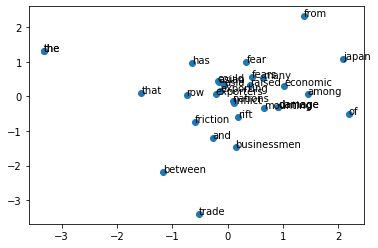

In [ ]:
from matplotlib import pyplot
result= compute_pca(emb_X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()